In [2]:
import carla
import subprocess
import random
import time
import numpy as np
import pandas as pd
import cv2
import os
import math
import matplotlib.pyplot as plt
from PIL import Image
import threading
import csv

In [2]:
import sys
sys.path.append(r"D:\programs\SelfDrive\libs\carla-0.9.14-py3.7-win-amd64.egg")
client = carla.Client("localhost", 2000)
client.set_timeout(20.0)
world = client.get_world()

import subprocess
import random
import time
import numpy as np
import pandas as pd
import cv2
import os
import math
import matplotlib.pyplot as plt
from PIL import Image
import open3d as o3d
import threading
import csv

# 1. Environment setup

In [3]:
#Simulation settings
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.1
world.apply_settings(settings)

2131

In [4]:
bp_lib = world.get_blueprint_library()
vehicle_blueprints = bp_lib.filter('vehicle.*')

In [5]:
vehicle_bp = bp_lib.find('vehicle.mini.cooper_s_2021')
vehicle_bp.set_attribute('color', '250, 240, 230')

1.1 Configuring a control agent to follow a predefined driving trajectory

In [6]:
#Generate a random driving trajectory
sys.path.append("D:/programs/SelfDrive/PythonAPI/carla")

from agents.navigation.global_route_planner import GlobalRoutePlanner
from agents.navigation.global_route_planner_dao import GlobalRoutePlannerDAO
from agents.navigation.behavior_agent import BehaviorAgent

def build_random_long_route(world, planner, min_distance=20000.0):
    spawn_points = world.get_map().get_spawn_points()

    start_transform = random.choice(spawn_points)
    current_location = start_transform.location

    total_route = []
    total_length = 0.0

    while total_length < min_distance:
        next_location = random.choice(spawn_points).location
        segment = planner.trace_route(current_location, next_location)

        if len(segment) < 2:
            continue

        for i in range(len(segment) - 1):
            wp1 = segment[i][0].transform.location
            wp2 = segment[i + 1][0].transform.location
            total_length += wp1.distance(wp2)

        total_route.extend(segment)
        current_location = next_location

    return start_transform, total_route

dao = GlobalRoutePlannerDAO(world.get_map(), sampling_resolution=1.0)
grp = GlobalRoutePlanner(dao, sampling_resolution=1.0)

In [7]:
spawn_transform, route = build_random_long_route(world, grp, min_distance=2600)
print(f"{len(route)} points on the route")

#Spawn vehicle at the beginning of the route
vehicle = world.spawn_actor(vehicle_bp, spawn_transform)

2778 points on the route


In [8]:
#Route planner for the predefined route
agent = BehaviorAgent(vehicle, behavior='aggressive')
agent.set_global_plan(route)

agent._local_planner._lane_change = False
agent._local_planner._buffer_size = 20
agent._local_planner._min_distance = 1.5     

In [9]:
#Route visualization
for waypoint, _ in route:
    world.debug.draw_point(
        waypoint.transform.location + carla.Location(z=1),
        size=0.1,
        color=carla.Color(255, 0, 0),
        life_time=30.0
    )

In [10]:
#For navigating the map
try:
    while True:
        world.tick()  
        time.sleep(0.01) 
except KeyboardInterrupt:
    print("stop")

stop


In [11]:
#Upcoming waypoints relative to the vehicle's current position
local_plan = agent.get_local_planner().get_plan()

1.2 Setting up and placing sensors

In [12]:
#RGB camera configuration
camera_bp = bp_lib.find('sensor.camera.rgb')

camera_bp.set_attribute("image_size_x", "1280")  
camera_bp.set_attribute("image_size_y", "720")
camera_bp.set_attribute('sensor_tick', '0.4')
camera_bp.set_attribute("fov", "90")

In [13]:
#RGB camera placement
camera_front = world.spawn_actor(
    camera_bp,
    carla.Transform(carla.Location(x=1.0, y=0.0, z=1.8), carla.Rotation(pitch=0.0, yaw=0.0, roll=0.0)),
    attach_to=vehicle 
)

camera_left = world.spawn_actor(
    camera_bp,
    carla.Transform(carla.Location(x=1.0, y=-0.5, z=1.8), carla.Rotation(yaw=-45)),
    attach_to=vehicle  
)

camera_right = world.spawn_actor(
    camera_bp,
    carla.Transform(carla.Location(x=1.0, y=0.5, z=1.8), carla.Rotation(yaw=45)),
    attach_to=vehicle  
)

In [14]:
#Semantic camera configuration
semantic_bp = bp_lib.find('sensor.camera.semantic_segmentation')

semantic_bp.set_attribute('image_size_x', '1280')
semantic_bp.set_attribute('image_size_y', '720')
semantic_bp.set_attribute('sensor_tick', '0.4')
semantic_bp.set_attribute("fov", "90")

In [15]:
#Placement of semantic cameras
semantic_camera_front = world.spawn_actor(
    semantic_bp,
    carla.Transform(carla.Location(x=1.0, y=0.0, z=1.8), carla.Rotation(pitch=0.0, yaw=0.0, roll=0.0)),
    attach_to=vehicle 
)

semantic_camera_left = world.spawn_actor(
    semantic_bp,
    carla.Transform(carla.Location(x=1.0, y=-0.5, z=1.8), carla.Rotation(yaw=-45)),
    attach_to=vehicle  
)

semantic_camera_right = world.spawn_actor(
    semantic_bp,
    carla.Transform(carla.Location(x=1.0, y=0.5, z=1.8), carla.Rotation(yaw=45)),
    attach_to=vehicle  
)

In [16]:
#Lidar configuration
lidar_bp = bp_lib.find('sensor.lidar.ray_cast')

lidar_bp.set_attribute('channels', '64.0') #Vertical resolution
lidar_bp.set_attribute('points_per_second', '500000') #Points per second
lidar_bp.set_attribute('range', '50.0') #Beam range,m
lidar_bp.set_attribute('rotation_frequency', '20.0') #Rotation frequency,Hz
lidar_bp.set_attribute('upper_fov', '15.0') #Upper field of view angle,deg
lidar_bp.set_attribute('lower_fov', '-35.0') #Lower field of view angle,deg
lidar_bp.set_attribute('sensor_tick', '0.4') #Lidar trigger period

In [17]:
#LiDAR placement
lidar_positions = {
    "lidar_roof": carla.Transform(
        carla.Location(x=-1.0, y=0.0, z=1.8), #position on the roof of the vehicle
        carla.Rotation(pitch=0.0, yaw=0.0, roll=0.0)
    ),
    "lidar_left": carla.Transform(
        carla.Location(x=0.5, y=-1.0, z=1.0), #position above the front left wheel
        carla.Rotation(pitch=0.0, yaw=90.0, roll=0.0) 
    ),
    "lidar_right": carla.Transform(
        carla.Location(x=0.5, y=1.0, z=1.0), #position above the front right wheel
        carla.Rotation(pitch=0.0, yaw=-90.0, roll=0.0) 
    ),
    "lidar_front": carla.Transform(
        carla.Location(x=2.0, y=0.0, z=0.9), #position on the front grille
        carla.Rotation(pitch=0.0, yaw=0.0, roll=0.0)  
    )
}

#Mounting LiDARs on the vehicle
lidars = {}
for name, transform in lidar_positions.items():
    lidar = world.spawn_actor(lidar_bp, transform, attach_to=vehicle)  
    lidars[name] = lidar

1.3 Creating city traffic

In [18]:
vehicles = world.get_actors().filter('vehicle.*')
traffic_manager = client.get_trafficmanager(8000)

def spawn_traffic(world, num_vehicles=20):
    blueprint_library = world.get_blueprint_library()
    spawn_points = world.get_map().get_spawn_points()
    random.shuffle(spawn_points)

    excluded_keywords = ['carlacola', 'cybertruck', 'firetruck',
                         'ambulance', 'european_hgv', 'crossbike',
                        'fusorosa', 'omafiets', 'century']

    vehicle_blueprints = [
        bp for bp in blueprint_library.filter('vehicle.*')
        if not any(keyword in bp.id for keyword in excluded_keywords)
    ]

    vehicles = []

    for i in range(min(num_vehicles, len(spawn_points))):  
        vehicle_bp = random.choice(vehicle_blueprints)

        if vehicle_bp.has_attribute('color'):
            color = random.choice(vehicle_bp.get_attribute('color').recommended_values)
            vehicle_bp.set_attribute('color', color)

        vehicle = world.try_spawn_actor(vehicle_bp, spawn_points[i])
        if vehicle:
            traffic_manager.set_synchronous_mode(True)
            traffic_manager.vehicle_percentage_speed_difference(vehicle, 0.0)
            traffic_manager.ignore_lights_percentage(vehicle, 0.0)
            traffic_manager.set_global_distance_to_leading_vehicle(1.5)
            traffic_manager.vehicle_lane_offset(vehicle, 0.0)
            vehicles.append(vehicle)

    return vehicles

vehicles_npc = spawn_traffic(world, num_vehicles=155)
print(f"{len(vehicles_npc)} NPC")

153 NPC


In [ ]:
#For navigating the map
try:
    while True:
        world.tick()  
        time.sleep(0.01) 
except KeyboardInterrupt:
    print("stop")

In [ ]:
#Enabling traffic autopilot
def enable_autopilot(vehicles, traffic_manager, autopilot_speed=20.0):
    
    for vehicle in vehicles:
        vehicle.set_autopilot(True, traffic_manager.get_port())
        traffic_manager.vehicle_percentage_speed_difference(vehicle, autopilot_speed)
        
enable_autopilot(vehicles_npc, traffic_manager)

In [9]:
#Destroying all actors
vehicles = world.get_actors().filter('vehicle.*')  
for vehicle in vehicles:
    vehicle.destroy()  
batch = []
for actor in world.get_actors().filter('*vehicle*'):
    batch.append(carla.command.DestroyActor(actor))
for actor in world.get_actors().filter('*sensor*'):
    batch.append(carla.command.DestroyActor(actor))

client.apply_batch_sync(batch, True)  

[]

# 2. Data generation

In [19]:
sensors = {
    "camera_front": camera_front,
    "camera_left": camera_left,
    "camera_right": camera_right,
    "semantic_camera_front": semantic_camera_front,
    "semantic_camera_left": semantic_camera_left,
    "semantic_camera_right": semantic_camera_right,
    "lidar_roof": lidars["lidar_roof"],
    "lidar_left": lidars["lidar_left"],
    "lidar_right": lidars["lidar_right"],
    "lidar_front": lidars["lidar_front"]
}

In [14]:
base_dir = "D:/programs/SelfDrive/DATA"

folders = {
    "camera_front": os.path.join(base_dir, "camera_front"),
    "camera_left": os.path.join(base_dir, "camera_left"),
    "camera_right": os.path.join(base_dir, "camera_right"),
    
    "semantic_camera_front": os.path.join(base_dir, "semantic_camera_front"),
    "semantic_camera_left": os.path.join(base_dir, "semantic_camera_left"),
    "semantic_camera_right": os.path.join(base_dir, "semantic_camera_right"),
    
    "lidar_combined": os.path.join(base_dir, "lidar_combined"),
    
    "lidar_projection_front": os.path.join(base_dir, "lidar_projection_front"),
    "lidar_projection_left": os.path.join(base_dir, "lidar_projection_left"),
    "lidar_projection_right": os.path.join(base_dir, "lidar_projection_right"),
    
    "vehicle_commands_file": os.path.join(base_dir, "vehicle_commands.csv"),
    "traffic_light_file": os.path.join(base_dir, "traffic_light.csv"),
    
    "trajectory": os.path.join(base_dir, "trajectory")
    
}

for key, path in folders.items():
    if not path.endswith(".csv"):
        os.makedirs(path, exist_ok=True)

In [15]:
#Initialization of the vehicle commands CSV file
vehicle_commands_file = folders["vehicle_commands_file"]
if not os.path.exists(folders["vehicle_commands_file"]):
    with open(folders["vehicle_commands_file"], mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["frame_id", "speed", "steer", "throttle", "brake"])  


#Initialization of the traffic light CSV fi
traffic_light_file = folders["traffic_light_file"]
if not os.path.exists(traffic_light_file):
    with open(traffic_light_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "frame_id", "object_id", "state"
        ])        

SENSORS = [
    "camera_front", "camera_left", "camera_right",
    "semantic_camera_front", "semantic_camera_left", "semantic_camera_right",
    "lidar_roof", "lidar_left", "lidar_right", "lidar_front",
    "vehicle_commands"
]

data_buffer = {}
lock = threading.Lock()

In [22]:
def save_data(frame_id):
    with lock:
        #Check for data availability for the frame
        if frame_id not in data_buffer:
            return

        data = data_buffer[frame_id]

        #Check if all sensor data has been recorded
        sensors_ready = all(sensor in data for sensor in SENSORS)
        if not sensors_ready:
            return

        #RGB cameras
        for cam in ["camera_front", "camera_left", "camera_right"]:
            data[cam].save_to_disk(os.path.join(folders[cam], f"{frame_id}.png"))

        #Semantic segmentation masks
        for cam in ["semantic_camera_front", "semantic_camera_left", "semantic_camera_right"]:
            np.save(os.path.join(folders[cam], f"{frame_id}.npy"), data[cam])

        #Vehicle control commands
        steer, throttle, brake, speed_kmh = data["vehicle_commands"]
        with open(folders["vehicle_commands_file"], mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([frame_id, speed_kmh, steer, throttle, brake])

        #Traffic light state
        traffic_light = agent._vehicle.get_traffic_light()
        with open(folders["traffic_light_file"], mode="a", newline="") as file:
            writer = csv.writer(file)
            if traffic_light and traffic_light.get_state().name.lower() != "off":
                state = traffic_light.get_state().name.lower()
                writer.writerow([frame_id, traffic_light.id, state])
        
        
        #Merging LiDAR point clouds
        process_lidar_scene(frame_id)

        #LiDAR projection onto images
        lidar_combined_path = os.path.join(folders["lidar_combined"], f"{frame_id}.npy")
        lidar_points = np.load(lidar_combined_path)

        for cam_name, suffix in zip(
            ["camera_front", "camera_left", "camera_right"],
            ["front", "left", "right"]
        ):
            camera = sensors[cam_name]
            world_to_cam = world_to_cam_matrix(camera)
            K = get_camera_intrinsics(camera)
            img_width = int(camera.attributes['image_size_x'])
            img_height = int(camera.attributes['image_size_y'])

            projected_points, depths = project_lidar_to_image(
                lidar_points, world_to_cam, K, img_width, img_height
            )

            proj_path = os.path.join(folders[f"lidar_projection_{suffix}"], f"{frame_id}.npz")
            np.savez(proj_path, pixels=projected_points, depths=depths)
            
        plan = agent.get_local_planner().get_plan()
        if len(plan) >= 20:
            vehicle_transform = agent._vehicle.get_transform()
            vehicle_loc = vehicle_transform.location

            trajectory_local = []
            for wp, _ in list(plan)[:20]:
                loc = wp.transform.location
                dx = loc.x - vehicle_loc.x
                dy = loc.y - vehicle_loc.y
                trajectory_local.append((dx, dy))

            traj_array = np.array(trajectory_local, dtype=np.float32)
            traj_path = os.path.join(folders["trajectory"], f"{frame_id}.npy")
            np.save(traj_path, traj_array)

        #Clearing the data buffer
        del data_buffer[frame_id]

In [23]:
#Process for capturing data from RGB cameras
def process_camera_image(image, sensor_name):
    frame_id = world.get_snapshot().frame  
    with lock:
        if frame_id not in data_buffer:
            data_buffer[frame_id] = {}
        data_buffer[frame_id][sensor_name] = image

#Process for capturing data from semantic cameras
def process_semantic_image(image, sensor_name):
    frame_id = world.get_snapshot().frame  

    mask = decode_semantic_image(image)

    with lock:
        if frame_id not in data_buffer:
            data_buffer[frame_id] = {}
        data_buffer[frame_id][sensor_name] = mask
    
def decode_semantic_image(image):
    array = np.frombuffer(image.raw_data, dtype=np.uint8)
    array = np.reshape(array, (image.height, image.width, 4))  
    semantic_mask = array[:, :, 2] 
    return semantic_mask

#Process for capturing lidar data
def process_lidar_data(lidar_data, sensor_name):
    frame_id = world.get_snapshot().frame

    #Convert raw lidar data into a point cloud
    points = np.frombuffer(lidar_data.raw_data, dtype=np.float32).reshape(-1, 4)

    with lock:
        if frame_id not in data_buffer:
            data_buffer[frame_id] = {}
        data_buffer[frame_id][sensor_name] = points[:, :3]  

#Transform data from different lidars into a common coordinate frame    
def process_lidar_scene(frame_id):
    if frame_id not in data_buffer:
        return

    all_points = []
    for lidar_name in ["lidar_roof", "lidar_left", "lidar_right", "lidar_front"]:
        if lidar_name in data_buffer[frame_id]:
            points = data_buffer[frame_id][lidar_name]
            transform = lidars[lidar_name].get_transform()
            matrix = np.array(transform.get_matrix())
            transformed = transform_points(points, matrix)
            all_points.append(transformed)
    if all_points:
        combined = np.vstack(all_points)
        data_buffer[frame_id]["lidar_combined"] = combined
        np.save(f"{folders['lidar_combined']}/{frame_id}.npy", combined) 
        
def transform_points(points, matrix):
    points_h = np.hstack((points, np.ones((points.shape[0], 1))))  
    transformed = (matrix @ points_h.T).T 
    return transformed[:, :3]

#Retrieve and save the trajectory from the agent
def process_trajectory(agent, frame_id):
    plan = agent.get_local_planner().get_plan()

    #Skip frame if there are fewer than 20 points in the plan
    if len(plan) < 20:
        return

    #Current position of the vehicle
    vehicle_transform = agent._vehicle.get_transform()
    vehicle_loc = vehicle_transform.location

    trajectory_local = []

    #First 20 points from the planned trajectory
    for wp, _ in list(plan)[:20]:
        loc = wp.transform.location
        dx = loc.x - vehicle_loc.x
        dy = loc.y - vehicle_loc.y
        trajectory_local.append((dx, dy))
        
    traj_array = np.array(trajectory_local, dtype=np.float32)
    np.save(os.path.join(folders["trajectory"], f"{frame_id}.npy"), traj_array)

def process_vehicle_commands(agent):
    frame_id = world.get_snapshot().frame  

    #Get control actions from the agent
    control = agent.run_step()

    #Apply control to the vehicle
    agent._vehicle.apply_control(control)

    #Get the current speed of the vehicle
    velocity = agent._vehicle.get_velocity()
    speed = (3.6 * (velocity.x ** 2 + velocity.y ** 2 + velocity.z ** 2) ** 0.5)

    commands = (control.steer, control.throttle, control.brake, speed)

    with lock:
        if frame_id not in data_buffer:
            data_buffer[frame_id] = {}
        data_buffer[frame_id]["vehicle_commands"] = commands  

    save_data(frame_id)

def record_commands(agent):
    while not stop_event.is_set():
        process_vehicle_commands(agent)
        
#Stop recording from all sensors        
def stop_recording():
    global stop_event
    stop_event.set()  
    for sensor in sensors.values():
        sensor.stop()  
        
stop_event = threading.Event()

In [24]:
#World-to-camera transformation matrix
def world_to_cam_matrix(camera_name):
    transform = camera_name.get_transform()
    
    location = transform.location
    rotation = transform.rotation
    
    yaw = np.radians(rotation.yaw)
    pitch = np.radians(rotation.pitch)
    roll = np.radians(rotation.roll)

    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_pitch = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_yaw = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    #Final camera rotation matrix
    R = R_yaw @ R_pitch @ R_roll
    R_inv = R.T  

    #Camera displacement matrix
    T = np.array([
        [1, 0, 0, -location.x],
        [0, 1, 0, -location.y],
        [0, 0, 1, -location.z],
        [0, 0, 0, 1]
    ])

    world_to_cam = np.eye(4)
    world_to_cam[:3, :3] = R_inv
    world_to_cam = world_to_cam @ T  

    #Correction matrix 
    A = np.array([
        [0, 1, 0],
        [0, 0, -1],
        [1, 0, 0]
    ])
    T_A = np.eye(4)
    
    T_A[:3, :3] = A

    world_to_cam_final = T_A @ world_to_cam
    
    return world_to_cam_final

#Camera intrinsic matrix
def get_camera_intrinsics(camera):
    width = int(camera.attributes['image_size_x']) 
    height = int(camera.attributes['image_size_y']) 
    fov = float(camera.attributes['fov']) 
    
    f_x = width / (2 * np.tan(np.radians(fov) / 2))
    f_y = f_x  

    c_x = width / 2
    c_y = height / 2

    K = np.array([
        [f_x, 0, c_x],
        [0, f_y, c_y],
        [0,  0,   1]
    ])
    
    return K
K = get_camera_intrinsics(camera_front)

In [25]:
def project_lidar_to_image(lidar_points, world_to_cam, K, img_width, img_height):
    N = lidar_points.shape[0]
    ones = np.ones((N, 1))

    #Add homogeneous coordinate
    lidar_points_hom = np.hstack((lidar_points, ones))  

    #Transform to camera coordinate system
    points_cam_hom = (world_to_cam @ lidar_points_hom.T).T  

    #Extract X, Y, Z coordinates in camera coordinate system
    X = points_cam_hom[:, 0]
    Y = points_cam_hom[:, 1]
    Z = points_cam_hom[:, 2]

    #Filter only points in front of the camera 
    valid_idx = Z > 0
    X_valid = X[valid_idx]
    Y_valid = Y[valid_idx]
    Z_valid = Z[valid_idx]

    if len(X_valid) == 0:
        return np.array([]), np.array([])  

    #Normalize coordinates
    x_norm = X_valid / Z_valid
    y_norm = Y_valid / Z_valid

    #Form normalized points
    points_norm = np.vstack((x_norm, y_norm, np.ones_like(x_norm)))  

    #Apply intrinsic matrix K to obtain pixel coordinates
    pixels_hom = K @ points_norm  

    #Convert coordinates to pixel values
    u = pixels_hom[0, :]
    v = pixels_hom[1, :]

    #Filter only points that fall inside the image
    mask = (u >= 0) & (u < img_width) & (v >= 0) & (v < img_height)

    return np.vstack((u[mask], v[mask])).T, Z_valid[mask]  #Coordinates and depth

In [ ]:
#Sensor activation
command_thread = threading.Thread(target=record_commands, args=(agent,), daemon=True)
command_thread.start()

camera_front.listen(lambda image: process_camera_image(image, "camera_front"))
camera_left.listen(lambda image: process_camera_image(image, "camera_left"))
camera_right.listen(lambda image: process_camera_image(image, "camera_right"))

semantic_camera_front.listen(lambda image: process_semantic_image(image, "semantic_camera_front"))
semantic_camera_left.listen(lambda image: process_semantic_image(image, "semantic_camera_left"))
semantic_camera_right.listen(lambda image: process_semantic_image(image, "semantic_camera_right"))

lidars["lidar_roof"].listen(lambda data: process_lidar_data(data, "lidar_roof"))
lidars["lidar_left"].listen(lambda data: process_lidar_data(data, "lidar_left"))
lidars["lidar_right"].listen(lambda data: process_lidar_data(data, "lidar_right"))
lidars["lidar_front"].listen(lambda data: process_lidar_data(data, "lidar_front"))

In [ ]:
stop_recording()

In [ ]:
#For navigating the map
try:
    while True:
        world.tick()  
        time.sleep(0.01) 
except KeyboardInterrupt:
    print("stop")

In [ ]:
#Simulation update for data recording
n = 50000

try:
    for i in range(n): 

        world.tick() 
        snapshot = world.get_snapshot()
        frame_id = snapshot.frame
        
        process_vehicle_commands(agent)
        
        time.sleep(0.4)
        if agent.done():
            print("done")
            break
except KeyboardInterrupt:
    print("stop")

# 3 Data visualization

3.1 Displaying RGB camera data for a random scene

In [10]:
base_dir = "D:/programs/SelfDrive/DATA"
scene_numb = 29551
ordered_cams = ["left", "front", "right"]

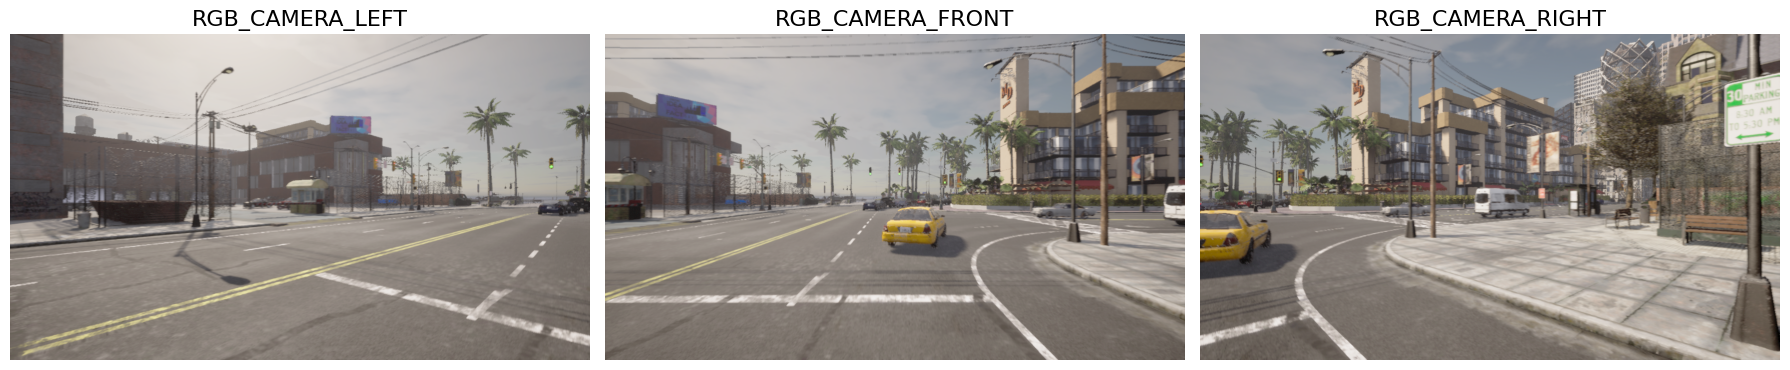

In [11]:
rgb_image_folders = {
    "left": os.path.join(base_dir, "camera_left"),
    "front": os.path.join(base_dir, "camera_front"),
    "right": os.path.join(base_dir, "camera_right"),
}

images = {}
for cam, path in rgb_image_folders.items():
    img = cv2.imread(os.path.join(path, f"{scene_numb}.png"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images[cam] = img

fig, axs = plt.subplots(1,3,figsize=(18,6))
for i, cam in enumerate(ordered_cams):
    axs[i].imshow(images[cam])
    axs[i].set_title(f"RGB_CAMERA_{cam.upper()}", fontsize=16)
    axs[i].axis("off")
    
plt.tight_layout()
plt.show()

In [16]:
#Control command output
df_commands = pd.read_csv(vehicle_commands_file)
frame_commands = df_commands[df_commands["frame_id"] == scene_numb]
frame_commands

,frame_id,speed,steer,throttle,brake
4436,29551,17.573919,0.000014,0.75,0.0


In [17]:
#Traffic light state output
df_traffic_light = pd.read_csv(traffic_light_file)
frame_traffic_light = df_traffic_light[df_traffic_light["frame_id"] == scene_numb]
frame_traffic_light

,frame_id,object_id,state
369,29551,22,green


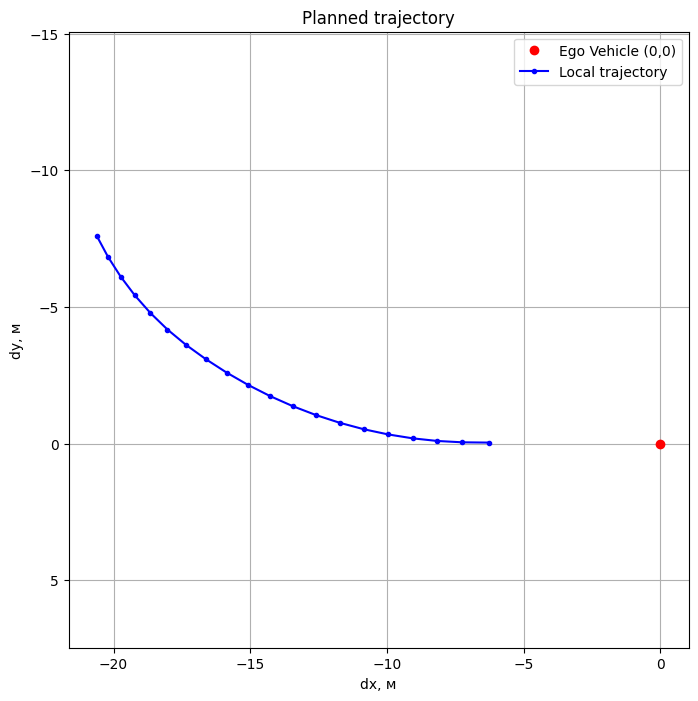

In [25]:
trajectory_path = os.path.join(base_dir, "trajectory", f"{scene_numb}.npy")
trajectory = np.load(trajectory_path)

ego_x, ego_y = 0, 0 

plt.figure(figsize=(8, 8))
plt.plot(ego_x, ego_y, 'ro', label="Ego Vehicle (0,0)")
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b.-', label="Local trajectory")

plt.title("Planned trajectory")
plt.xlabel("dx, м")
plt.ylabel("dy, м")
plt.grid(True)
plt.axis('equal')
plt.gca().invert_yaxis()  
plt.legend()
plt.show()

3.2 Displaying data from semantic cameras for a random scene

In [18]:
#Available class IDs in CARLA
labels = []
for attr in dir(carla.CityObjectLabel):
    if not attr.startswith("__"):
        value = getattr(carla.CityObjectLabel, attr)
        if isinstance(value, carla.CityObjectLabel):
            labels.append({"ID": int(value), "Class Name": attr})
df_classes = pd.DataFrame(labels).sort_values("ID").reset_index(drop=True)
print(df_classes.to_string(index=False))

 ID   Class Name
  0         NONE
  1        Roads
  2    Sidewalks
  3    Buildings
  4        Walls
  5       Fences
  6        Poles
  7 TrafficLight
  8 TrafficSigns
  9   Vegetation
 10      Terrain
 11          Sky
 12  Pedestrians
 13        Rider
 14          Car
 15        Truck
 16          Bus
 17        Train
 18   Motorcycle
 19      Bicycle
 20       Static
 21      Dynamic
 22        Other
 23        Water
 24    RoadLines
 25       Ground
 26       Bridge
 27    RailTrack
 28    GuardRail
255          Any


In [19]:
CARLA_CLASSES = {
    0: (0, 0, 0),             
    1: (70, 70, 70),         
    2: (190, 153, 153),      
    3: (72, 0, 90),           
    4: (220, 20, 60),         
    5: (255, 20, 147),           
    6: (192, 192, 192),       
    7: (255, 255, 0),         
    8: (0, 139, 139),         
    9: (0, 128, 0),            
    10: (139, 69, 19),          
    11: (0, 0, 255),        
    12: (0, 0, 142),          
    13: (255, 255, 240),
    14: (220, 20, 60),
    15: (220, 20, 60),
    16: (220, 20, 60),
    17: (220, 20, 60),
    18: (220, 20, 60),
    19: (220, 20, 60),
    20: (47, 79, 79),
    21: (255, 99, 71),
    22: (192, 192, 192),
    23: (0, 170, 255),
    24: (184, 134, 11),
    25: (139, 69, 19),
    26: (255, 255, 240),
    27: (255, 255, 240),
    28: (255, 255, 240),
    255: (255, 255, 240),
}

def colorize_semantic_mask(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label_id, color in CARLA_CLASSES.items():
        color_mask[mask == label_id] = color
    return color_mask

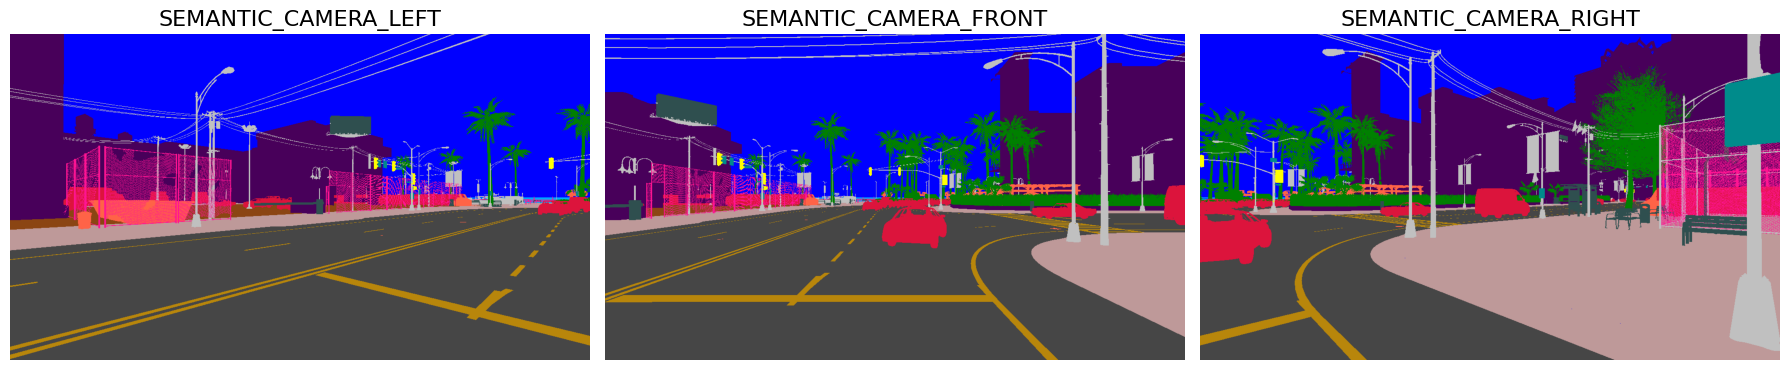

In [20]:
semantic_image_folders = {
    "left": os.path.join(base_dir, "semantic_camera_left"),
    "front": os.path.join(base_dir, "semantic_camera_front"),
    "right": os.path.join(base_dir, "semantic_camera_right"),
}

masks = {}
for cam in semantic_image_folders:
    path = f"{semantic_image_folders[cam]}/{scene_numb}.npy"
    masks[cam] = np.load(path)
    
fig, axs = plt.subplots(1,3,figsize=(18,6))
for i, cam in enumerate(ordered_cams):
    mask = masks[cam]
    color = colorize_semantic_mask(mask)
    axs[i].imshow(color)
    axs[i].set_title(f"SEMANTIC_CAMERA_{cam.upper()}", fontsize=16)
    axs[i].axis("off")
plt.tight_layout()
plt.show()

In [21]:
for cam in ordered_cams:
    path = f"{base_dir}/semantic_camera_{cam}/{scene_numb}.npy"
    mask = np.load(path)

    unique_classes = np.unique(mask)
    print(f"SEMANTIC_CAMERA_{cam.upper()}:")
    print("Classes:", unique_classes)
    print("Number of classes:", len(unique_classes), '\n')

SEMANTIC_CAMERA_LEFT:
Classes: [ 1  2  3  4  5  6  7  8  9 11 14 15 20 21 22 23 24 25]
Number of classes: 18 

SEMANTIC_CAMERA_FRONT:
Classes: [ 1  2  3  4  5  6  7  8  9 11 14 15 20 21 22 23 24 25]
Number of classes: 18 

SEMANTIC_CAMERA_RIGHT:
Classes: [ 1  2  3  4  5  6  7  8  9 11 13 14 15 18 20 21 22 23 24 25]
Number of classes: 20 



3.3 Visualization of the merged LiDAR point cloud for a random scene

In [ ]:
import plotly.graph_objects as go

def plot_lidar_3d_plotly(frame_id):
    file_path = os.path.join(base_dir, 'lidar_combined', f"{frame_id}.npy")
    if not os.path.exists(file_path):
        print(f"file {file_path} not found")
        return

    points = np.load(file_path)
    x, y, z = points[:, 1], points[:, 0], points[:, 2]

    fig = go.Figure(data=[
        go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(
                size=1.5,
                color=z,       
                colorscale='Viridis',
                opacity=0.8
            )
        )
    ])

    fig.update_layout(
        scene=dict(
            xaxis_title='X (м)',
            yaxis_title='Y (м)',
            zaxis_title='Z (м)',
            aspectmode='data'
        ),
        title=f"Lidar Scene {frame_id}",
        margin=dict(l=0, r=0, t=40, b=0)
    )

    fig.show()

plot_lidar_3d_plotly(scene_numb)

In [6]:
#Visualization in Open3D
import open3d as o3d

def visualize_lidar_scene(frame_id):
    file_path = os.path.join(base_dir, 'lidar_combined', f"{frame_id}.npy")
    if not os.path.exists(file_path):
        return
    
    points = np.load(file_path)
    points[:, [0, 1]] = points[:, [1, 0]] 
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    o3d.visualization.draw_geometries([pcd], window_name=f"Lidar Scene {frame_id}")
    
visualize_lidar_scene(scene_numb)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


3.4 Projection of merged LiDAR point cloud onto camera planes for a random scene

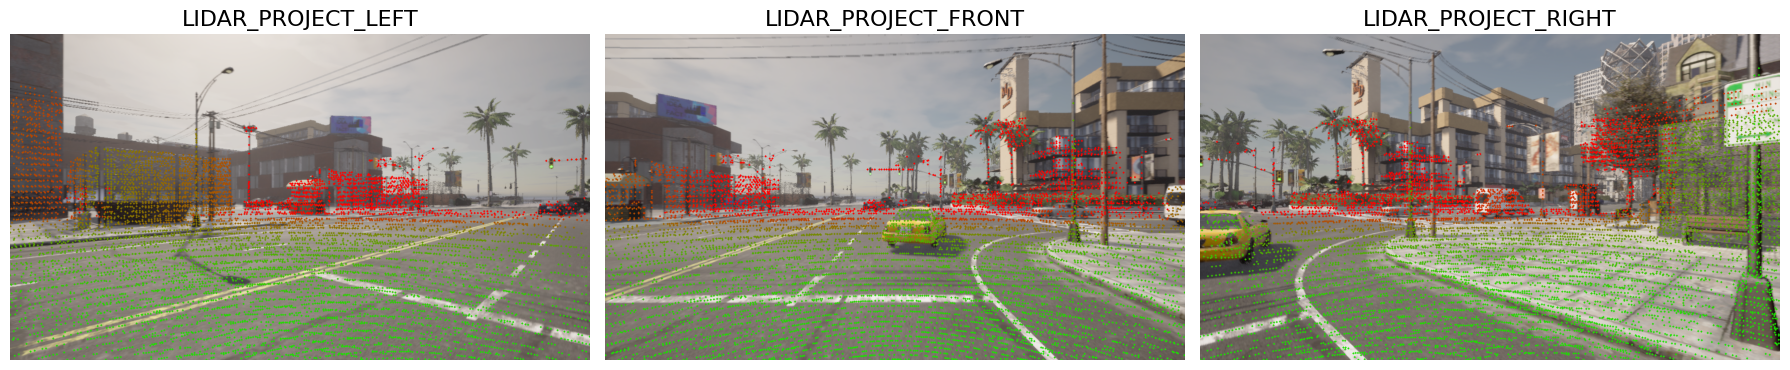

In [24]:
lidar_projection_folders = {
    "left": os.path.join(base_dir, "lidar_projection_left"),
    "front": os.path.join(base_dir, "lidar_projection_front"),
    "right": os.path.join(base_dir, "lidar_projection_right"),
}

images = {}
for cam in ["left", "front", "right"]:
    #Loading image
    img_path = os.path.join(rgb_image_folders[cam], f"{scene_numb}.png")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Loading projection
    proj_path = os.path.join(lidar_projection_folders[cam], f"{scene_numb}.npz")
    proj = np.load(proj_path)
    pixels = proj["pixels"]
    depths = proj["depths"]

    #Overlaying points on the image
    for (u, v), d in zip(pixels, depths):
        d_norm = np.clip(d / 30.0, 0, 1.0)

        r = int(255 * d_norm)
        g = int(255 * (1 - d_norm))
        b = 0
        color = (r, g, b)
        cv2.circle(img, (int(u), int(v)), 2, color, -1)

    images[cam] = img

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ordered_cams = ["left", "front", "right"]

for i, cam in enumerate(ordered_cams):
    axs[i].imshow(images[cam])
    axs[i].set_title(f"LIDAR_PROJECT_{cam.upper()}", fontsize=16)
    axs[i].axis("off")

plt.tight_layout()
plt.show()